# Generate emissions paths
Firstly we generate reasonable CO2 total emissions, based on the emissions in the SR1.5 database. Then we infill the other emissions from this. 
# CO2 pathway

In [1]:
import numpy as np
import os.path
import pandas as pd
import pyam
import pymagicc
import scmdata
import silicone.multiple_infillers as mi
import silicone.database_crunchers.quantile_rolling_windows as qrw

<IPython.core.display.Javascript object>

In [2]:
version = "v4"
outdir = f"../output/{version}/"

In [3]:
sr15_em = pyam.IamDataFrame("../input/complete_sr15_emissions.csv").filter(region="World")
sr15_em.data

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ..\input\complete_sr15_emissions.csv


,model,scenario,region,variable,unit,year,value
0,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2005,8.336700
1,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2010,7.640800
2,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2015,7.272400
3,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2020,7.075200
4,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2025,5.848600
...,...,...,...,...,...,...,...
245906,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,Emissions|Sulfur,Mt SO2/yr,2060,32.966164
245907,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,Emissions|Sulfur,Mt SO2/yr,2070,32.053593
245908,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,Emissions|Sulfur,Mt SO2/yr,2080,30.864629
245909,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,Emissions|Sulfur,Mt SO2/yr,2090,29.142678


In [7]:
complete_sr15 = pyam.IamDataFrame("../input/complete_sr15.csv").filter(region="World")

pyam.core - INFO: Reading file ..\input\complete_sr15.csv


In [8]:
complete_sr15.variable

['AR5 climate diagnostics|Concentration|CO2|FAIR|MED',
 'AR5 climate diagnostics|Concentration|CO2|MAGICC6|MED',
 'AR5 climate diagnostics|Forcing|Aerosol|Direct|MAGICC6|MED',
 'AR5 climate diagnostics|Forcing|Aerosol|MAGICC6|MED',
 'AR5 climate diagnostics|Forcing|Aerosol|Total|FAIR|MED',
 'AR5 climate diagnostics|Forcing|Aerosol|Total|MAGICC6|MED',
 'AR5 climate diagnostics|Forcing|CH4|FAIR|MED',
 'AR5 climate diagnostics|Forcing|CH4|MAGICC6|MED',
 'AR5 climate diagnostics|Forcing|CO2|FAIR|MED',
 'AR5 climate diagnostics|Forcing|CO2|MAGICC6|MED',
 'AR5 climate diagnostics|Forcing|F-Gases|MAGICC6|MED',
 'AR5 climate diagnostics|Forcing|FAIR|MED',
 'AR5 climate diagnostics|Forcing|Kyoto Gases|MAGICC6|MED',
 'AR5 climate diagnostics|Forcing|MAGICC6|MED',
 'AR5 climate diagnostics|Forcing|Montreal Protocol (orig.) gases|MAGICC6|MED',
 'AR5 climate diagnostics|Forcing|N2O|FAIR|MED',
 'AR5 climate diagnostics|Forcing|N2O|MAGICC6|MED',
 'AR5 climate diagnostics|Forcing|OtherGHGs|FAIR|MED',


<AxesSubplot:title={'center':'scenario: SSP5-34 - region: World - variable: AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|Expected value'}, xlabel='Year', ylabel='°C'>

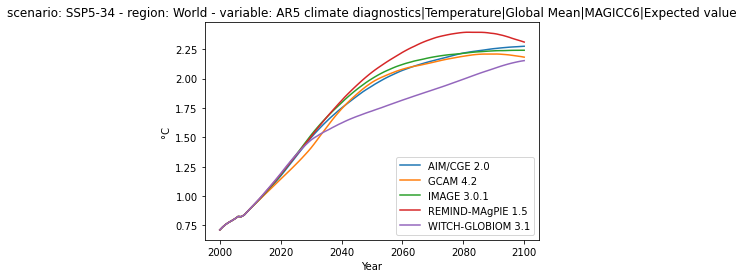

In [10]:
complete_sr15.filter(scenario="SSP5-34", variable="AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|Expected value").plot()

In [4]:
scenario = "SSP2-45"
model = "MESSAGE-GLOBIOM 1.0"

In [5]:
sr15_em_int = sr15_em.interpolate([2025, 2035, 2045, 2055, 2065, 2075, 2085, 2095])

<AxesSubplot:>

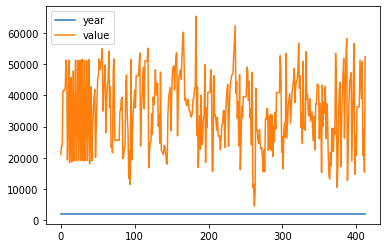

In [6]:
co2tot = "Emissions|CO2"
co2afolu = "Emissions|CO2|AFOLU"
co2ei = "Emissions|CO2|Energy and Industrial Processes"
sr15_em_int.filter(year=2030, variable=co2tot).data.plot()

sr15_em_int.filter(year=2035, variable=co2tot).data.plot()

<AxesSubplot:>

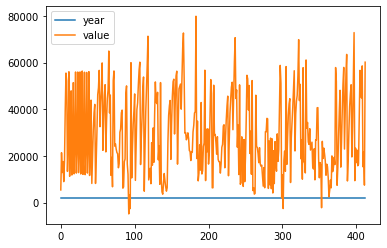

In [7]:
sr15_em_int.filter(year=2040, variable=co2tot).data.plot()

In [8]:
ratios = sr15_em_int.filter(variable="*CO2").timeseries()
ratios["ratio"] = ratios[2030]/ratios[2020]
ratios["diff2040_2030"] = ratios[2040] - ratios[2030]
ratios

2000  \
model             scenario               region variable      unit              
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|CO2 Mt CO2/yr   NaN   
                  ADVANCE_2020_Med2C     World  Emissions|CO2 Mt CO2/yr   NaN   
                  ADVANCE_2020_WB2C      World  Emissions|CO2 Mt CO2/yr   NaN   
                  ADVANCE_2030_Med2C     World  Emissions|CO2 Mt CO2/yr   NaN   
                  ADVANCE_2030_Price1.5C World  Emissions|CO2 Mt CO2/yr   NaN   
...                                                                       ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi           World  Emissions|CO2 Mt CO2/yr   NaN   
                  CD-LINKS_NPi2020_1000  World  Emissions|CO2 Mt CO2/yr   NaN   
                  CD-LINKS_NPi2020_1600  World  Emissions|CO2 Mt CO2/yr   NaN   
                  CD-LINKS_NPi2020_400   World  Emissions|CO2 Mt CO2/yr   NaN   
                  CD-LINKS_NoPolicy      World  Emissions|CO2 Mt CO2/yr   NaN   

                                                                         2001  \
model             scenario               region variable      unit              
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|CO2 Mt CO2/yr   NaN   
                  ADVANCE_2020_Med2C     World  Emissions|CO2 Mt CO2/yr   NaN   
                  ADVANCE_2020_WB2C      World  Emissions|CO2 Mt CO2/yr   NaN   
                  ADVANCE_2030_Med2C     World  Emissions|CO2 Mt CO2/yr   NaN   
                  ADVANCE_2030_Price1.5C World  Emissions|CO2 Mt CO2/yr   NaN   
...                                                                       ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi           World  Emissions|CO2 Mt CO2/yr   NaN   
                  CD-LINKS_NPi2020_1000  World  Emissions|CO2 Mt CO2/yr   NaN   
                  CD-LINKS_NPi2020_1600  World  Emissions|CO2 Mt CO2/yr   NaN   
                  CD-LINKS_NPi2020_400   World  Emissions|CO2 Mt CO2/yr   NaN   
                  CD-LINKS_NoPolicy      World  Emissions|CO2 Mt CO2/yr   NaN   

                                                                         2002  \
model             scenario               region variable      unit              
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|CO2 Mt CO2/yr   NaN   
                  ADVANCE_2020_Med2C     World  Emissions|CO2 Mt CO2/yr   NaN   
                  ADVANCE_2020_WB2C      World  Emissions|CO2 Mt CO2/yr   NaN   
                  ADVANCE_2030_Med2C     World  Emissions|CO2 Mt CO2/yr   NaN   
                  ADVANCE_2030_Price1.5C World  Emissions|CO2 Mt CO2/yr   NaN   
...                                                                       ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi           World  Emissions|CO2 Mt CO2/yr   NaN   
                  CD-LINKS_NPi2020_1000  World  Emissions|CO2 Mt CO2/yr   NaN   
                  CD-LINKS_NPi2020_1600  World  Emissions|CO2 Mt CO2/yr   NaN   
                  CD-LINKS_NPi2020_400   World  Emissions|CO2 Mt CO2/yr   NaN   
                  CD-LINKS_NoPolicy      World  Emissions|CO2 Mt CO2/yr   NaN   

                                                                         2003  \
model             scenario               region variable      unit              
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|CO2 Mt CO2/yr   NaN   
                  ADVANCE_2020_Med2C     World  Emissions|CO2 Mt CO2/yr   NaN   
                  ADVANCE_2020_WB2C      World  Emissions|CO2 Mt CO2/yr   NaN   
                  ADVANCE_2030_Med2C     World  Emissions|CO2 Mt CO2/yr   NaN   
                  ADVANCE_2030_Price1.5C World  Emissions|CO2 Mt CO2/yr   NaN   
...                                                                       ...   
WITCH-GLOBIOM 4.4 CD-LINKS_NPi           World  Emissions|CO2 Mt CO2/yr   NaN   
                  CD-LINKS_NPi2020_1000  World  Emissions|CO2 Mt CO2/yr   NaN   
                  CD-LINKS_NPi2020_1600  World  Emissions|CO2 Mt CO2/yr   NaN   
                  CD

In [9]:
min(ratios.ratio)

0.11855040813124396

In [10]:
max(ratios.ratio)

1.3601769745833048

In [11]:
min_dif = min(ratios["diff2040_2030"])
min_dif

-32751.7725

In [12]:
max_dif = max(ratios["diff2040_2030"])
max_dif

16255.461109999997

In [13]:
basis_scen = sr15_em_int.filter(model=model, scenario=scenario, year=[2010, 2015, 2020])
years = np.arange(2010, 2301, 10)
centyears = [2010, 2015] + list(np.arange(2020, 2101, 10))

In [14]:
try:
    del all_scens
except NameError:
    pass
yeargap = 10
min_netz = 2040 # None of the scenarios meet net 0 by 2035 so this is the earliest round numb
max_grad = 5000
overshoots = [0, -2500, -5000, -7500, -10000]
for mod_2030 in np.arange(0.12, 1.32, 0.2):
    for net_zero in [i for i in np.arange(min_netz, 2101, yeargap)] + [2150, 2200]:
        for overshoot in overshoots:
            scen = basis_scen.filter(variable="*CO2").timeseries()
            scen[2030] = scen[2020] * mod_2030
            for year in range(2030 + yeargap, min(net_zero + 1, 2301), yeargap):
                scen[year] = scen[2030] * (net_zero - year) / (net_zero - 2030)
            for year in range(net_zero + yeargap, 2301, yeargap):
                scen[year] = max([overshoot, scen[year - yeargap].values - max_grad])
            if (scen[2040] - scen[2030] - min_dif).values[0] < 0:
                continue
            scen = scen.reset_index()
            scen["scenario"] = f"2030fact{round(mod_2030, 3)}_nz{net_zero}_ov{overshoot}"
            try:
                all_scens = all_scens.append(scen)
            except NameError:
                all_scens = scen
all_scens = pyam.IamDataFrame(all_scens)

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: MESSAGE-GLOBIOM 1.0 - region: World - variable: Emissions|CO2'}, xlabel='Year', ylabel='Mt CO2/yr'>

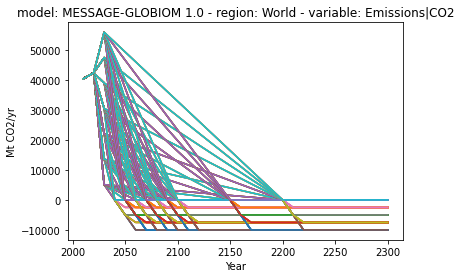

In [15]:
all_scens.plot()

# Break down CO2 total and infill non-CO2 emissions
Break down CO2 total

In [16]:
co2_infiller = mi.SplitCollectionWithRemainderEmissions(sr15_em)
co2_breakdown = co2_infiller.infill_components(co2tot, [co2afolu], co2ei, all_scens.filter(year=centyears))

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: MESSAGE-GLOBIOM 1.0 - region: World - variable: Emissions|CO2|Energy and Industrial Processes'}, xlabel='Year', ylabel='Mt CO2/yr'>

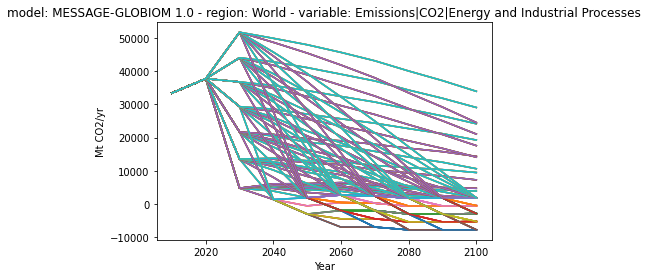

In [17]:
co2_breakdown.filter(variable=co2ei).plot()

In [18]:
co2_breakdown

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : MESSAGE-GLOBIOM 1.0 (1)
 * scenario : 2030fact0.12_nz2040_ov-10000, ... 2030fact1.32_nz2200_ov0 (300)
Timeseries data coordinates:
   region   : World (1)
   variable : Emissions|CO2|AFOLU, ... (2)
   unit     : Mt CO2/yr (1)
   year     : 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, ... 2100 (10)
Meta indicators:
   exclude (bool) False (1)

In [19]:
all_scens = all_scens.append(co2_breakdown)

In [20]:
# Infill methane emissions
scenarios = []
methane_infiller = qrw.QuantileRollingWindows(sr15_em)
for methane_level in [0.25, 0.5, 0.75]:
    methane_scen = all_scens.copy().data
    methane_scen["scenario"] = methane_scen["scenario"] + "_meth{}".format(round(methane_level, 3))
    methane_vals = methane_infiller.derive_relationship(
        "Emissions|CH4", ["Emissions|CO2"], quantile=methane_level
    )(pyam.IamDataFrame(methane_scen).filter(year=centyears))
    scenarios.append(pyam.IamDataFrame(methane_scen))
    scenarios.append(methane_vals)

In [40]:
all_scens.filter(variable="*CH4").timeseries()

2010  \
model               scenario                              region variable      unit                    
MESSAGE-GLOBIOM 1.0 2030fact0.12_nz2040_ov-10000_meth0.25 World  Emissions|CH4 Mt CH4/yr  326.395571   
                    2030fact0.12_nz2040_ov-10000_meth0.5  World  Emissions|CH4 Mt CH4/yr  326.467070   
                    2030fact0.12_nz2040_ov-10000_meth0.75 World  Emissions|CH4 Mt CH4/yr  371.114068   
                    2030fact0.12_nz2040_ov-2500_meth0.25  World  Emissions|CH4 Mt CH4/yr  326.395571   
                    2030fact0.12_nz2040_ov-2500_meth0.5   World  Emissions|CH4 Mt CH4/yr  326.467070   
...                                                                                              ...   
                    2030fact1.32_nz2200_ov-7500_meth0.5   World  Emissions|CH4 Mt CH4/yr  326.467070   
                    2030fact1.32_nz2200_ov-7500_meth0.75  World  Emissions|CH4 Mt CH4/yr  371.114068   
                    2030fact1.32_nz2200_ov0_meth0.25      World  Emissions|CH4 Mt CH4/yr  326.395571   
                    2030fact1.32_nz2200_ov0_meth0.5       World  Emissions|CH4 Mt CH4/yr  326.467070   
                    2030fact1.32_nz2200_ov0_meth0.75      World  Emissions|CH4 Mt CH4/yr  371.114068   

                                                                                                2020  \
model               scenario                              region variable      unit                    
MESSAGE-GLOBIOM 1.0 2030fact0.12_nz2040_ov-10000_meth0.25 World  Emissions|CH4 Mt CH4/yr  350.561789   
                    2030fact0.12_nz2040_ov-10000_meth0.5  World  Emissions|CH4 Mt CH4/yr  386.367072   
                    2030fact0.12_nz2040_ov-10000_meth0.75 World  Emissions|CH4 Mt CH4/yr  404.624759   
                    2030fact0.12_nz2040_ov-2500_meth0.25  World  Emissions|CH4 Mt CH4/yr  350.561789   
                    2030fact0.12_nz2040_ov-2500_meth0.5   World  Emissions|CH4 Mt CH4/yr  386.367072   
...                                                                                              ...   
                    2030fact1.32_nz2200_ov-7500_meth0.5   World  Emissions|CH4 Mt CH4/yr  386.367072   
                    2030fact1.32_nz2200_ov-7500_meth0.75  World  Emissions|CH4 Mt CH4/yr  404.624759   
                    2030fact1.32_nz2200_ov0_meth0.25      World  Emissions|CH4 Mt CH4/yr  350.561789   
                    2030fact1.32_nz2200_ov0_meth0.5       World  Emissions|CH4 Mt CH4/yr  386.367072   
                    2030fact1.32_nz2200_ov0_meth0.75      World  Emissions|CH4 Mt CH4/yr  404.624759   

                                                                                                2030  \
model               scenario                              region variable      unit                    
MESSAGE-GLOBIOM 1.0 2030fact0.12_nz2040_ov-10000_meth0.25 World  Emissions|CH4 Mt CH4/yr  165.201876   
                    2030fact0.12_nz2040_ov-10000_meth0.5  World  Emissions|CH4 Mt CH4/yr  232.363385   
                    2030fact0.12_nz2040_ov-10000_meth0.75 World  Emissions|CH4 Mt CH4/yr  280.033452   
                    2030fact0.12_nz2040_ov-2500_meth0.25  World  Emissions|CH4 Mt CH4/yr  165.201876   
                    2030fact0.12_nz2040_ov-2500_meth0.5   World  Emissions|CH4 Mt CH4/yr  232.363385   
...                                                                                              ...   
                    2030fact1.32_nz2200_ov-7500_meth0.5   World  Emissions|CH4 Mt CH4/yr  434.417096   
                    2030fact1.32_nz2200_ov-7500_meth0.75  World  Emissions|CH4 Mt CH4/yr  468.423898   
                    2030fact1.32_nz2200_ov0_meth0.25      World  Emissions|CH4 Mt CH4/yr  381.970273   
                    2030fact1.32_nz2200_ov0_meth0.5       World  Emissions|CH4 Mt CH4/yr  434.417096   
                    2030fact1.32_nz2200_ov0_meth0.75      World  Emissions|CH4 Mt CH4/yr  468.423898   

                                     

In [21]:
all_scens = pyam.concat(scenarios)

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: MESSAGE-GLOBIOM 1.0 - region: World - variable: Emissions|CH4'}, xlabel='Year', ylabel='Mt CH4/yr'>

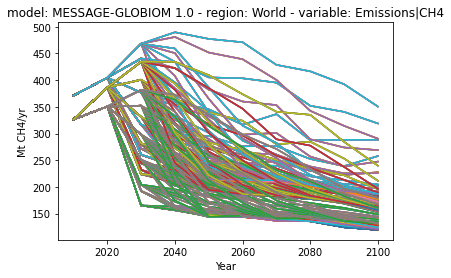

In [22]:
all_scens.filter(variable="Emissions|CH4").plot()

In [23]:
# Infill the remaining emissions
required_variables_list = [
            "Emissions|BC",
            "Emissions|PFC|CF4",
            "Emissions|PFC|C2F6",
            "Emissions|PFC|C6F14",
            "Emissions|CO",
            "Emissions|HFC|HFC134a",
            "Emissions|HFC|HFC143a",
            "Emissions|HFC|HFC227ea",
            "Emissions|HFC|HFC23",
            "Emissions|HFC|HFC32",
            "Emissions|HFC|HFC43-10",
            "Emissions|HFC|HFC245ca",
            "Emissions|HFC|HFC125",
            "Emissions|N2O",
            "Emissions|NH3",
            "Emissions|NOx",
            "Emissions|OC",
            "Emissions|SF6",
            "Emissions|Sulfur",
            "Emissions|VOC",
        ]
other_infilled = mi.infill_all_required_variables(all_scens.filter(year=centyears), sr15_em, [co2tot])

c:\users\rlamboll\constraincode\silicone\src\silicone\multiple_infillers\infill_all_required_emissions_for_openscm.py:191: UserWarning: No data for ['Emissions|HFC|HFC245ca'], it will be infilled with 0s
  unavailable_variables
silicone.database_crunchers.constant_ratio - INFO: <class 'silicone.database_crunchers.constant_ratio.ConstantRatio'> won't use any information from the database
Filling required variables: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.49it/s]


Note that the lead variable ['Emissions|CO2'] goes negative.


Filling required variables: 100%|██████████████████████████████████████████████████████| 22/22 [00:06<00:00,  3.26it/s]


In [24]:
other_infilled.filter(variable="*PFC*").data

,model,scenario,region,variable,unit,year,value
0,MESSAGE-GLOBIOM 1.0,2030fact0.12_nz2040_ov-10000_meth0.25,World,Emissions|PFC|C2F6,kt C2F6/yr,2015,4.936813
1,MESSAGE-GLOBIOM 1.0,2030fact0.12_nz2040_ov-10000_meth0.25,World,Emissions|PFC|C2F6,kt C2F6/yr,2020,4.158928
2,MESSAGE-GLOBIOM 1.0,2030fact0.12_nz2040_ov-10000_meth0.25,World,Emissions|PFC|C2F6,kt C2F6/yr,2030,1.334045
3,MESSAGE-GLOBIOM 1.0,2030fact0.12_nz2040_ov-10000_meth0.25,World,Emissions|PFC|C2F6,kt C2F6/yr,2040,0.818667
4,MESSAGE-GLOBIOM 1.0,2030fact0.12_nz2040_ov-10000_meth0.25,World,Emissions|PFC|C2F6,kt C2F6/yr,2050,0.479899
...,...,...,...,...,...,...,...
26995,MESSAGE-GLOBIOM 1.0,2030fact1.32_nz2200_ov0_meth0.75,World,Emissions|PFC|CF4,kt CF4/yr,2060,15.847395
26996,MESSAGE-GLOBIOM 1.0,2030fact1.32_nz2200_ov0_meth0.75,World,Emissions|PFC|CF4,kt CF4/yr,2070,15.506313
26997,MESSAGE-GLOBIOM 1.0,2030fact1.32_nz2200_ov0_meth0.75,World,Emissions|PFC|CF4,kt CF4/yr,2080,13.350901
26998,MESSAGE-GLOBIOM 1.0,2030fact1.32_nz2200_ov0_meth0.75,World,Emissions|PFC|CF4,kt CF4/yr,2090,3.247801


In [25]:
#for variable in other_infiller.variable:
#    other_infiller.filter(variable=variable).plot()

<AxesSubplot:title={'center':'region: World - variable: Emissions|SF6'}, xlabel='Year', ylabel='kt SF6/yr'>

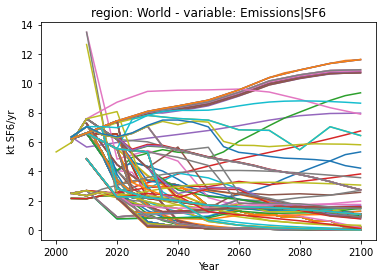

In [26]:
sr15_em.filter(variable="*SF6").plot(legend=False)

In [27]:
sr15_em.filter(variable="*C2F6").timeseries()

2005  \
model                       scenario                   region variable           unit                   
IEA World Energy Model 2017 Faster Transition Scenario World  Emissions|PFC|C2F6 kt C2F6/yr  2.649467   
IMAGE 3.0.1                 IMA15-AGInt                World  Emissions|PFC|C2F6 kt C2F6/yr  2.070116   
                            IMA15-Def                  World  Emissions|PFC|C2F6 kt C2F6/yr  2.070116   
                            IMA15-Eff                  World  Emissions|PFC|C2F6 kt C2F6/yr  2.070116   
                            IMA15-LiStCh               World  Emissions|PFC|C2F6 kt C2F6/yr  2.070116   
                            IMA15-LoNCO2               World  Emissions|PFC|C2F6 kt C2F6/yr  2.070116   
                            IMA15-Pop                  World  Emissions|PFC|C2F6 kt C2F6/yr  2.070116   
                            IMA15-RenElec              World  Emissions|PFC|C2F6 kt C2F6/yr  2.070116   
                            IMA15-TOT                  World  Emissions|PFC|C2F6 kt C2F6/yr  2.070116   

                                                                                                 2010  \
model                       scenario                   region variable           unit                   
IEA World Energy Model 2017 Faster Transition Scenario World  Emissions|PFC|C2F6 kt C2F6/yr  2.456150   
IMAGE 3.0.1                 IMA15-AGInt                World  Emissions|PFC|C2F6 kt C2F6/yr  3.754667   
                            IMA15-Def                  World  Emissions|PFC|C2F6 kt C2F6/yr  3.754667   
                            IMA15-Eff                  World  Emissions|PFC|C2F6 kt C2F6/yr  3.754667   
                            IMA15-LiStCh               World  Emissions|PFC|C2F6 kt C2F6/yr  3.754667   
                            IMA15-LoNCO2               World  Emissions|PFC|C2F6 kt C2F6/yr  3.754667   
                            IMA15-Pop                  World  Emissions|PFC|C2F6 kt C2F6/yr  3.754667   
                            IMA15-RenElec              World  Emissions|PFC|C2F6 kt C2F6/yr  3.754667   
                            IMA15-TOT                  World  Emissions|PFC|C2F6 kt C2F6/yr  3.754667   

                                                                                                 2015  \
model                       scenario                   region variable           unit                   
IEA World Energy Model 2017 Faster Transition Scenario World  Emissions|PFC|C2F6 kt C2F6/yr  2.303700   
IMAGE 3.0.1                 IMA15-AGInt                World  Emissions|PFC|C2F6 kt C2F6/yr  4.936813   
                            IMA15-Def                  World  Emissions|PFC|C2F6 kt C2F6/yr  4.936813   
                            IMA15-Eff                  World  Emissions|PFC|C2F6 kt C2F6/yr  4.936813   
                            IMA15-LiStCh               World  Emissions|PFC|C2F6 kt C2F6/yr  4.936813   
                            IMA15-LoNCO2               World  Emissions|PFC|C2F6 kt C2F6/yr  4.936813   
                            IMA15-Pop                  World  Emissions|PFC|C2F6 kt C2F6/yr  4.936813   
                            IMA15-RenElec              World  Emissions|PFC|C2F6 kt C2F6/yr  4.936813   
                            IMA15-TOT                  World  Emissions|PFC|C2F6 kt C2F6/yr  4.936813   

                                                                                                 2020  \
model                       scenario                   region variable           unit                   
IEA World Energy Model 2017 Faster Transition Scenario World  Emissions|PFC|C2F6 kt C2F6/yr  2.151250   
IMAGE 3.0.1                 IMA15-AGInt                World  Emissions|PFC|C2F6 kt C2F6/yr  4.158928   
                            IMA15-Def                  World  Emissions|PFC|C2F6 kt C2F6/yr  4.158928   
                            IMA15-Eff                  World  Emissions|PFC|C2F6 kt C2F6/yr  4.158928   

In [28]:
sr15_em.filter(variable="*CF4").timeseries()

2005  \
model                       scenario                   region variable          unit                  
IEA World Energy Model 2017 Faster Transition Scenario World  Emissions|PFC|CF4 kt CF4/yr  11.60590   
IMAGE 3.0.1                 IMA15-AGInt                World  Emissions|PFC|CF4 kt CF4/yr  10.56032   
                            IMA15-Def                  World  Emissions|PFC|CF4 kt CF4/yr  10.56032   
                            IMA15-Eff                  World  Emissions|PFC|CF4 kt CF4/yr  10.56032   
                            IMA15-LiStCh               World  Emissions|PFC|CF4 kt CF4/yr  10.56032   
                            IMA15-LoNCO2               World  Emissions|PFC|CF4 kt CF4/yr  10.56032   
                            IMA15-Pop                  World  Emissions|PFC|CF4 kt CF4/yr  10.56032   
                            IMA15-RenElec              World  Emissions|PFC|CF4 kt CF4/yr  10.56032   
                            IMA15-TOT                  World  Emissions|PFC|CF4 kt CF4/yr  10.56032   

                                                                                               2010  \
model                       scenario                   region variable          unit                  
IEA World Energy Model 2017 Faster Transition Scenario World  Emissions|PFC|CF4 kt CF4/yr  16.40915   
IMAGE 3.0.1                 IMA15-AGInt                World  Emissions|PFC|CF4 kt CF4/yr  13.70864   
                            IMA15-Def                  World  Emissions|PFC|CF4 kt CF4/yr  13.70864   
                            IMA15-Eff                  World  Emissions|PFC|CF4 kt CF4/yr  13.70864   
                            IMA15-LiStCh               World  Emissions|PFC|CF4 kt CF4/yr  13.70864   
                            IMA15-LoNCO2               World  Emissions|PFC|CF4 kt CF4/yr  13.70864   
                            IMA15-Pop                  World  Emissions|PFC|CF4 kt CF4/yr  13.70864   
                            IMA15-RenElec              World  Emissions|PFC|CF4 kt CF4/yr  13.70864   
                            IMA15-TOT                  World  Emissions|PFC|CF4 kt CF4/yr  13.70864   

                                                                                                2015  \
model                       scenario                   region variable          unit                   
IEA World Energy Model 2017 Faster Transition Scenario World  Emissions|PFC|CF4 kt CF4/yr  16.033325   
IMAGE 3.0.1                 IMA15-AGInt                World  Emissions|PFC|CF4 kt CF4/yr  16.051769   
                            IMA15-Def                  World  Emissions|PFC|CF4 kt CF4/yr  16.051769   
                            IMA15-Eff                  World  Emissions|PFC|CF4 kt CF4/yr  16.051769   
                            IMA15-LiStCh               World  Emissions|PFC|CF4 kt CF4/yr  16.051769   
                            IMA15-LoNCO2               World  Emissions|PFC|CF4 kt CF4/yr  16.051769   
                            IMA15-Pop                  World  Emissions|PFC|CF4 kt CF4/yr  16.051769   
                            IMA15-RenElec              World  Emissions|PFC|CF4 kt CF4/yr  16.051769   
                            IMA15-TOT                  World  Emissions|PFC|CF4 kt CF4/yr  16.051769   

                                                                                               2020  \
model                       scenario                   region variable          unit                  
IEA World Energy Model 2017 Faster Transition Scenario World  Emissions|PFC|CF4 kt CF4/yr  15.65750   
IMAGE 3.0.1                 IMA15-AGInt                World  Emissions|PFC|CF4 kt CF4/yr  12.77657   
                            IMA15-Def                  World  Emissions|PFC|CF4 kt CF4/yr  12.77657   
                            IMA15-Eff                  World  Emissions|PFC|CF4 kt CF4/yr  12.77657   
                            IMA15-LiStCh               World  Em

In [29]:
other_infilled = pyam.IamDataFrame(other_infilled)

In [30]:
other_infilled.timeseries()

2015  \
model               scenario                              region variable            unit                        
MESSAGE-GLOBIOM 1.0 2030fact0.12_nz2040_ov-10000_meth0.25 World  Emissions|BC        Mt BC/yr         7.349054   
                                                                 Emissions|CH4       Mt CH4/yr      338.478680   
                                                                 Emissions|CO        Mt CO/yr       858.830614   
                                                                 Emissions|CO2       Mt CO2/yr    41289.611275   
                                                                 Emissions|CO2|AFOLU Mt CO2/yr     5764.782035   
...                                                                                                        ...   
                    2030fact1.32_nz2200_ov0_meth0.75      World  Emissions|PFC|C6F14 kt C6F14/yr      1.330952   
                                                                 Emissions|PFC|CF4   kt CF4/yr       16.051769   
                                                                 Emissions|SF6       kt SF6/yr        6.068700   
                                                                 Emissions|Sulfur    Mt SO2/yr       88.945502   
                                                                 Emissions|VOC       Mt VOC/yr      181.810722   

                                                                                                          2020  \
model               scenario                              region variable            unit                        
MESSAGE-GLOBIOM 1.0 2030fact0.12_nz2040_ov-10000_meth0.25 World  Emissions|BC        Mt BC/yr         7.207993   
                                                                 Emissions|CH4       Mt CH4/yr      350.561789   
                                                                 Emissions|CO        Mt CO/yr       823.760027   
                                                                 Emissions|CO2       Mt CO2/yr    42284.928730   
                                                                 Emissions|CO2|AFOLU Mt CO2/yr     4596.363875   
...                                                                                                        ...   
                    2030fact1.32_nz2200_ov0_meth0.75      World  Emissions|PFC|C6F14 kt C6F14/yr      0.702248   
                                                                 Emissions|PFC|CF4   kt CF4/yr       12.776570   
                                                                 Emissions|SF6       kt SF6/yr        4.281028   
                                                                 Emissions|Sulfur    Mt SO2/yr       84.840592   
                                                                 Emissions|VOC       Mt VOC/yr      177.386236   

                                                                                                         2030  \
model               scenario                              region variable            unit                       
MESSAGE-GLOBIOM 1.0 2030fact0.12_nz2040_ov-10000_meth0.25 World  Emissions|BC        Mt BC/yr        4.991303   
                                                                 Emissions|CH4       Mt CH4/yr     165.201876   
                                                                 Emissions|CO        Mt CO/yr      721.350556   
                                                                 Emissions|CO2       Mt CO2/yr    5074.191448   
                                                                 Emissions|CO2|AFOLU Mt CO2/yr     281.543493   
...                                                                                                       ...   
                    2030fact1.32_nz2200_ov0_meth0.75      World  Emissions|PFC|C6F14 kt C6F14/yr     0.200316   
                                                                 Emissions|PFC|CF4   kt CF4/yr      13.259137   
          

# Extend the scenarios to end of 2300

In [31]:
last_vals = other_infilled.filter(year=2100).filter(variable=[co2tot, co2ei], keep=False).data
all_years_extension = []
extend_years = [y for y in all_scens.year if y > 2100]
for year in extend_years:
    year_val = last_vals.copy()
    year_val["year"] = year
    all_years_extension.append(year_val)
extensions = pyam.concat(all_years_extension)
extensions

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : MESSAGE-GLOBIOM 1.0 (1)
 * scenario : 2030fact0.12_nz2040_ov-10000_meth0.25, ... (900)
Timeseries data coordinates:
   region   : World (1)
   variable : Emissions|BC, Emissions|CH4, Emissions|CO, ... Emissions|VOC (22)
   unit     : Mt BC/yr, Mt CH4/yr, Mt CO/yr, Mt CO2-equiv/yr, ... kt SF6/yr (22)
   year     : 2110, 2120, 2130, 2140, 2150, 2160, 2170, 2180, ... 2300 (20)
Meta indicators:
   exclude (bool) False (1)

In [32]:
extensions2 = extensions.append(all_scens.filter(year=extend_years))
extend_eni = extensions2.subtract(co2tot, co2afolu, co2ei, ignore_units=True)
extend_eni = extend_eni.rename(unit={"unknown": "Mt CO2/yr"})
extend_eni

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : MESSAGE-GLOBIOM 1.0 (1)
 * scenario : 2030fact0.12_nz2040_ov-10000_meth0.25, ... (900)
Timeseries data coordinates:
   region   : World (1)
   variable : Emissions|CO2|Energy and Industrial Processes (1)
   unit     : Mt CO2/yr (1)
   year     : 2110, 2120, 2130, 2140, 2150, 2160, 2170, 2180, ... 2300 (20)
Meta indicators:
   exclude (bool) False (1)

In [33]:
other_infilled = pyam.concat([other_infilled, extensions2, extend_eni])

In [41]:
other_infilled.scenario

['2030fact0.12_nz2040_ov-10000_meth0.25',
 '2030fact0.12_nz2040_ov-10000_meth0.5',
 '2030fact0.12_nz2040_ov-10000_meth0.75',
 '2030fact0.12_nz2040_ov-2500_meth0.25',
 '2030fact0.12_nz2040_ov-2500_meth0.5',
 '2030fact0.12_nz2040_ov-2500_meth0.75',
 '2030fact0.12_nz2040_ov-5000_meth0.25',
 '2030fact0.12_nz2040_ov-5000_meth0.5',
 '2030fact0.12_nz2040_ov-5000_meth0.75',
 '2030fact0.12_nz2040_ov-7500_meth0.25',
 '2030fact0.12_nz2040_ov-7500_meth0.5',
 '2030fact0.12_nz2040_ov-7500_meth0.75',
 '2030fact0.12_nz2040_ov0_meth0.25',
 '2030fact0.12_nz2040_ov0_meth0.5',
 '2030fact0.12_nz2040_ov0_meth0.75',
 '2030fact0.12_nz2050_ov-10000_meth0.25',
 '2030fact0.12_nz2050_ov-10000_meth0.5',
 '2030fact0.12_nz2050_ov-10000_meth0.75',
 '2030fact0.12_nz2050_ov-2500_meth0.25',
 '2030fact0.12_nz2050_ov-2500_meth0.5',
 '2030fact0.12_nz2050_ov-2500_meth0.75',
 '2030fact0.12_nz2050_ov-5000_meth0.25',
 '2030fact0.12_nz2050_ov-5000_meth0.5',
 '2030fact0.12_nz2050_ov-5000_meth0.75',
 '2030fact0.12_nz2050_ov-7500_

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: MESSAGE-GLOBIOM 1.0 - region: World - variable: Emissions|CO2'}, xlabel='Year', ylabel='Mt CO2/yr'>

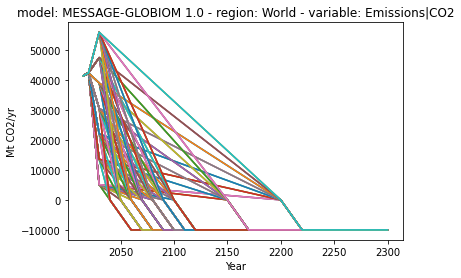

In [42]:
other_infilled.filter(variable=co2tot, scenario=["*ov-10000*", "ov-5000", "ov-0"]).plot()

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: MESSAGE-GLOBIOM 1.0 - region: World - variable: Emissions|CO2'}, xlabel='Year', ylabel='Mt CO2/yr'>

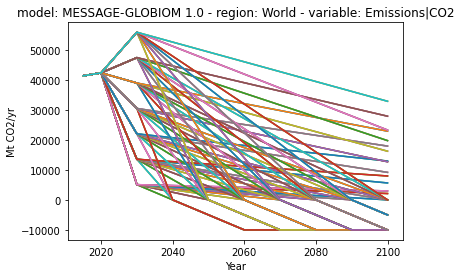

In [43]:
other_infilled.filter(variable=co2tot, scenario=["*ov-10000*", "ov-5000", "ov-0"], year=np.arange(2000, 2101, 5)).plot()

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: MESSAGE-GLOBIOM 1.0 - region: World - variable: Emissions|CH4'}, xlabel='Year', ylabel='Mt CH4/yr'>

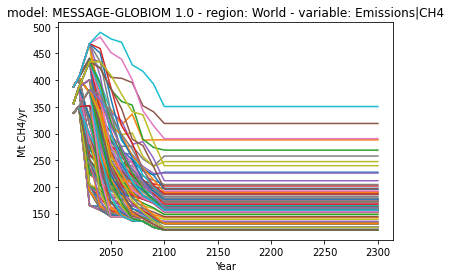

In [44]:
other_infilled.filter(variable="*CH4", scenario=["*ov-10000*", "ov-5000", "ov-0"]).plot()

# Save answer

In [34]:
csv_em_file = outdir + "senarios_{}.csv"
scen_file = outdir + "scen_{}"
other_infilled.to_csv(csv_em_file.format(version))

In [35]:
def construct_scen_file(infilled_data, scen_file_name):
    """Function to construct scen file"""
    def rename_variables(v):
        """Format variables to MAGICC variable convention"""
        mapping = {
        'Emissions|HFC|HFC143a':'Emissions|HFC143a',
        'Emissions|HFC|HFC245ca':"Emissions|HFC245fa",
        'Emissions|CO2|AFOLU':'Emissions|CO2|MAGICC AFOLU',
        'Emissions|HFC|HFC43-10': 'Emissions|HFC4310',
        'Emissions|HFC|HFC32':'Emissions|HFC32',
        'Emissions|HFC|HFC125':'Emissions|HFC125',
        'Emissions|HFC|HFC227ea':'Emissions|HFC227ea',
        'Emissions|CO2|Energy and Industrial Processes': 'Emissions|CO2|MAGICC Fossil and Industrial',
        'Emissions|HFC|HFC134a':'Emissions|HFC134a',
        'Emissions|HFC|HFC23':'Emissions|HFC23',
        'Emissions|PFC|CF4': 'Emissions|CF4',
        'Emissions|PFC|C2F6': 'Emissions|C2F6',
        'Emissions|PFC|C6F14': 'Emissions|C6F14',
        'Emissions|Sulfur': 'Emissions|SOx',
        'Emissions|VOC':'Emissions|NMVOC'
        }
    
        try:
            return mapping[v]
        except KeyError:
            return v

    def replace_units(u):
        """Replace units for NOx"""
            
        mapping = {
            'Mt NOX/yr': 'Mt NO2 / yr',
        }
        try:
            return mapping[u]
        except KeyError:
            return u

    # Filter out HFC and non HFC - unit conversions
    non_hfc = infilled_data.filter(variable=["Emissions|HFC*", "Emissions|PFC*"], keep=False)
    hfc = infilled_data.filter(variable=["Emissions|HFC*", "Emissions|PFC*"]).data
    
    # Work around for HFC345ca
    hfc["unit"] = hfc["variable"].apply(
        lambda x: 
        "kt {} / yr".format(
            x
            .split("|")[-1]
            .replace("-", "")
            .replace("245ca", "245fa")
        )
    )
    hfc = pyam.IamDataFrame(hfc)
    enCO2 = non_hfc.filter(variable="Emissions|CO2|Energy and Industrial Processes").data
    enCO2["unit"] = "Mt CO2/yr"
    enCO2 = pyam.IamDataFrame(enCO2)
    non_hfc = non_hfc.filter(
        variable = "Emissions|CO2|Energy and Industrial Processes",
        keep = False
    ).append(enCO2)
    non_hfc = non_hfc.convert_unit("Mt NH3/yr", to="Mt N/yr", factor=14/17)

    # Create an SCM dataframe 
    scen_scm = scmdata.ScmRun(hfc.append(non_hfc))
    writer = pymagicc.io.MAGICCData(scen_scm)
    vars_not_used = [
        "Emissions|CO2", 
        "Emissions|F-Gases",
        'Emissions|kyotoghg_excl_lulucf'    
    ]
    writer = writer.filter(variable=vars_not_used, keep=False)
    # Check whether all the variables are named appropriately
    expected_names = [
        pymagicc.definitions.convert_magicc7_to_openscm_variables(f"{v}_EMIS") 
        for v in pymagicc.definitions.PART_OF_SCENFILE_WITH_EMISSIONS_CODE_1
    ]

    writer["variable"] = writer["variable"].apply(rename_variables)
    writer["unit"] = writer["unit"].apply(replace_units)
    writer["todo"] = "SET"
        
    missing_names = set(expected_names) - set(writer["variable"].unique())
    assert not missing_names, missing_names
    problematic_names = set(writer["variable"].unique()) - set(expected_names)
    assert not problematic_names, problematic_names

    # Unit conversion and cleaning 
    unit_specs = pymagicc.definitions.MAGICC7_EMISSIONS_UNITS.set_index("magicc_variable")
    for v in writer["variable"]:
            magicc_var = pymagicc.definitions.convert_magicc7_to_openscm_variables(
                v, inverse=True).replace("T_EMIS", "").replace("_EMIS", "")
            magicc_unit = unit_specs.loc[magicc_var, "emissions_unit"]
            writer = writer.convert_unit(magicc_unit, variable=v)
    
    # Now we add the 2000 data from the SR1.5 SCEN files to ensure MAGICC doesn't
    # assume constant emissions between 2000 and the start of the SCEN file
    base_scen_file = os.path.join(
        os.path.dirname(os.path.abspath("__file__")),
        "..",
        "sr15_scenfiles",
        "scenfiles",
        "IPCCSR15_REMIND-MAgPIE 1.7-3.0_PEP_2C_red_netzero_GAS.SCEN",
    )
    extra_hist = pymagicc.io.MAGICCData(base_scen_file).filter(
        year = range(1, writer["year"].min()),
        region = "World"
    )

    # Overwrite model, scenario names
    extra_hist["scenario"] = writer.get_unique_meta("scenario",True)
    extra_hist["model"] = writer.get_unique_meta("model", True)
    extra_hist["unit"] = extra_hist["unit"].apply(
        lambda x: (
            x
            .replace("134a", "134A")
            .replace("143a", "143A")
            .replace("245fa", "245FA")
            .replace("227ea", "227EA")
        )
    )

    writer = pymagicc.io.MAGICCData(pd.concat(
        [
            extra_hist.timeseries(time_axis="year", meta=writer.timeseries().index.names),
            writer.timeseries(time_axis="year"),
        ],
        axis=1,
    ))
    # Write the scen file
    writer.write("{}.SCEN".format(scen_file_name), magicc_version=6)

In [36]:
for scenario in other_infilled.scenario:
    construct_scen_file(other_infilled.filter(scenario=scenario), scen_file.format(scenario))